# Projet numérique de Science des Données 2025

__Binôme numéro 69 -- CAILLAUT Gustave et DE RIVIERE Zéphyr__

## Introduction

Dans ce projet, il s'agira d'étudier un jeu de données concernant des femmes diabétiques enceintes. Le diabète constitue un facteur de risque pour le bon déroulé de la grossesse. Pour chacune de ces femmes, nous disposons de 7 variables :
* `Age` : l'âge en années
* `Tension systolique` : la tension systolique en mmHg
* `Tension diastolique` : la tension diastolique en mmHg
* `Glycémie` : glycémie post-prandiale en mmol/L
* `Température` : température en °C
* `FC au repos` : fréquence cardiaque au repos
* `Risque` : degré de risque obstétrique (0 : faible, 1 : moyen, 2 : élevé)


Ce projet comporte trois partie :
1. Une analyse exploratoire des données
2. La construction d'un classifieur binaire permettant de séparer les femmes dont la grossesse est à risque de celles dont elle ne l'est pas
3. La construction d'un classifieur multi-classe permettant de séparer les grossesses en trois classes : hautement à risque, moyennement à risque, faiblement à risque.

## Instructions 
* Former un binôme et l'inscrire dans Moodle.
* Renseigner le numéro de binôme et vos noms tout en haut de ce notebook à l'emplacement indiqué.
* Déposer ce notebook complété **au plus tard le 10 juillet 2025, 23h59** sur Moodle.

La présence aux séances dédiés au mini-projet (20/06 et 7/07) est **notée**. 

Les questions **1 à 14** peuvent être traitées dès la première séance. 
La question **15** peut être traitée après la PC4.
Les questions **16 à 30** peuvent être traitées à partir de la PC5.

Pour des raisons pédagogiques (voir la note à ce sujet), **l'usage d'assistants de code ou d'agents conversationnels tels que ChatGPT, Copilot, Claude, LeChat est prohibé. Leur utilisation sera sanctionnée.**

### Question 1 (1pt)

Les données ont été récoltées dans une région défavorisée du monde, où les populations sont très pauvres et peuvent difficilement consulter. Quel peut être l'intérêt de déléguer à un algorithme la prédiction du risque obstétrique ? Quelles peuvent être les dérives (sociales, éthiques, économiques, psychologiques) d'une telle pratique ?

#### Réponse 

Comme ces femmes consultent rarement un médecin, il peut être difficile de détecter des traces de risque obstétrique chez celles-ci. Ainsi peut-il être intéressant d'utiliser un algorithme pour prévoir le risque.

Pour ce qui est des risques de dérives, il peut y avoir des fuites de données médicales confidentielles. Exploiter ces données pour entraîner un algorithme peut par ailleurs être considéré immoral par certains, et il ne faut pas que ces démarches remplacent un diagnostic médical concret. 

## Librairies usuelles

In [3]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', **{'size': 12}) # règle la taille de police globalement pour les plots (en pt)

np.random.seed(19) 

## Chargement des données

Nous allons pour l'instant travailler avec le jeu de données d'entraînement `data/donnees_entrainement.csv` :

In [4]:
df_train = pd.read_csv('data/donnees_entrainement.csv')

Commençons par en extraire deux arrays, `X_train` et `y_train`, contenant d'une part les variables décrivant les observations et d'autre part leurs étiquettes :

In [5]:
X_train = np.array(df_train.drop('Risque', axis=1))
y_train = np.array(df_train['Risque'], dtype='int')

# 1. Exploration de données

## Distributions des variables

### Question 2 (1 pt)
Pour chaque variable, affichez un histogramme de sa distribution dans chacune des trois classes.

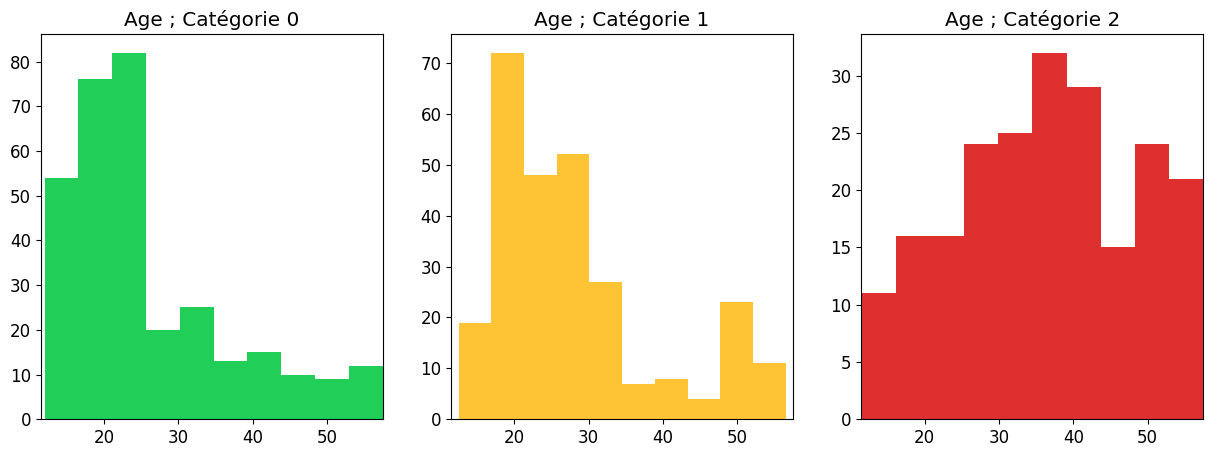

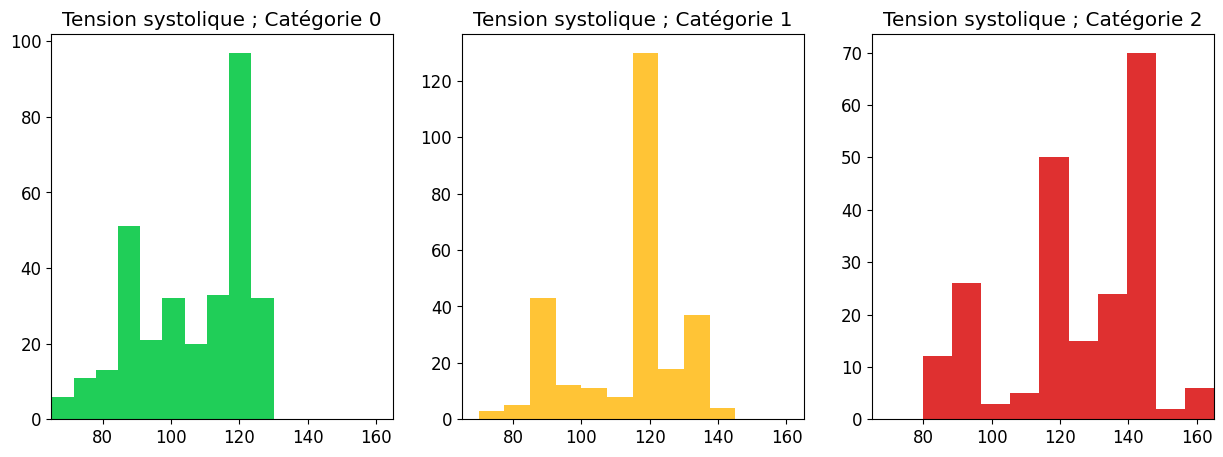

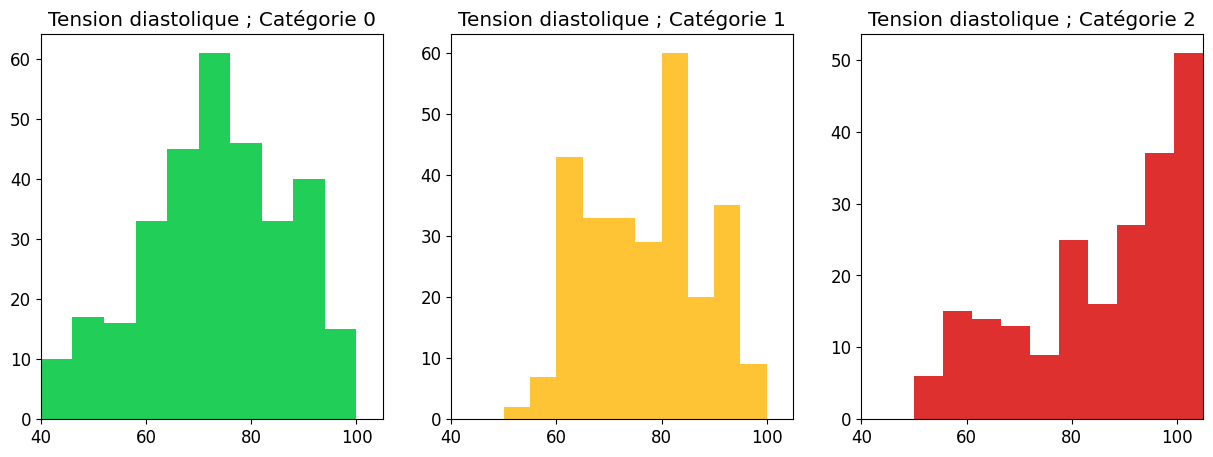

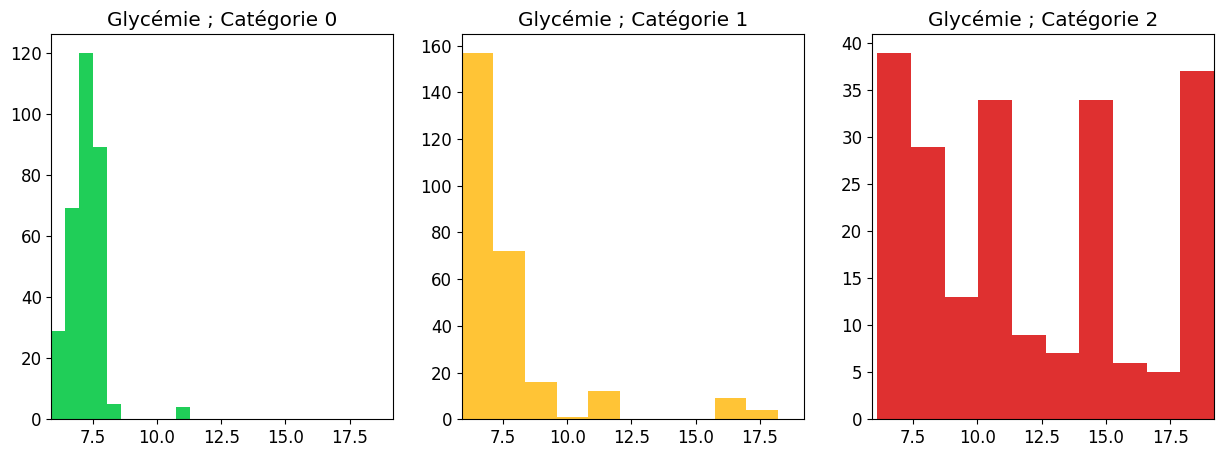

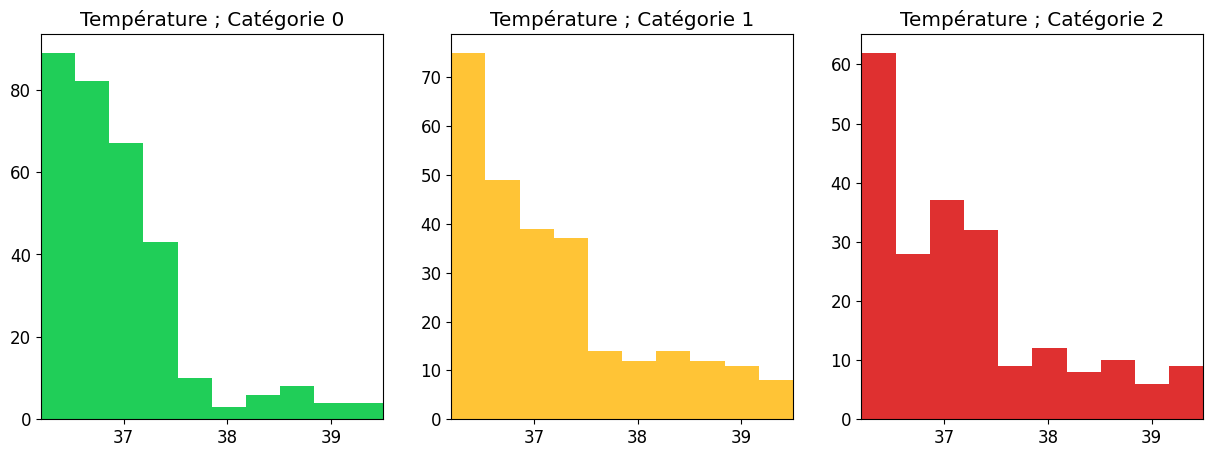

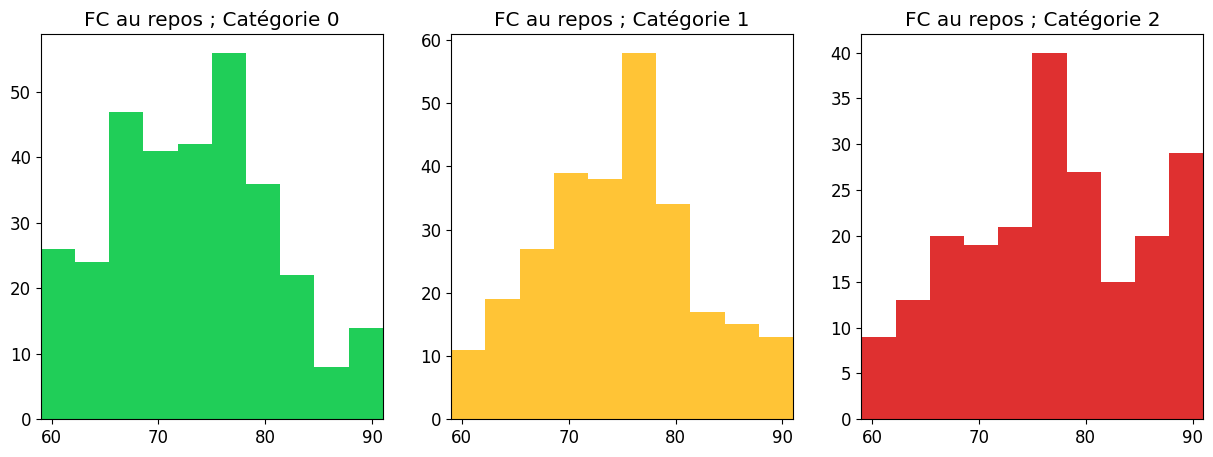

In [6]:
colors=["#20CE58", "#ffc436", "#df3030"]

for c in df_train.columns[:-1]:
    fig = plt.figure(figsize=(15, 5))
    for i in range(0, 3):
        ax = fig.add_subplot(1, 3, i+1)
        plt.hist(df_train[c][df_train["Risque"] == i], color=colors[i])
        ax.set_xlim(df_train[c].min(), df_train[c].max())
        ax.set_title(c + " ; Catégorie " + str(i))
        

### Question 3 (1 pt)
Les valeurs prises par ces variables sont-elles surprenantes ? Cohérentes avec le degré de risque ?

#### Réponse

Les données ne sont pas vraiment surprenantes. On s'attend à ce que les patientes à haut risque soient plus agées, avec un plus haut taux glycémique et une tension plus extrême. 
La température et la fréquence cardiaque semblent jouer un rôle plus mineur, bien que il y ait moins de patientes atteintes de fièvre (température > 37.5) dans la catégorie 0.

### Question 4 (1 pt)
Pensez-vous qu'il va être facile/difficile de prédire le risque de grossesse à risque en utilisant ces 6 variables ?

#### Réponse

Nous semblons apercevoir des corréations mais il paraît difficile d'en dégager des causalités immédiatement. On préfèrerait peut-être les combiner pour dégager de meilleurs liens entre les variables et la prédiction

## Réduction de dimension

Indépendamment de votre réponse à la question précédente, nous allons procéder à deux tentatives de réduction de dimension.

### Question 5 (1 pt)
Utilisez la décomposition en composantes principales de `X_train` pour visualiser les données en deux dimensions.

In [7]:
from sklearn import preprocessing
from sklearn import decomposition

In [8]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
pca_train = decomposition.PCA(n_components=2)
pca_train.fit(X_train_scaled)
X_train_projected = pca_train.transform(X_train_scaled)

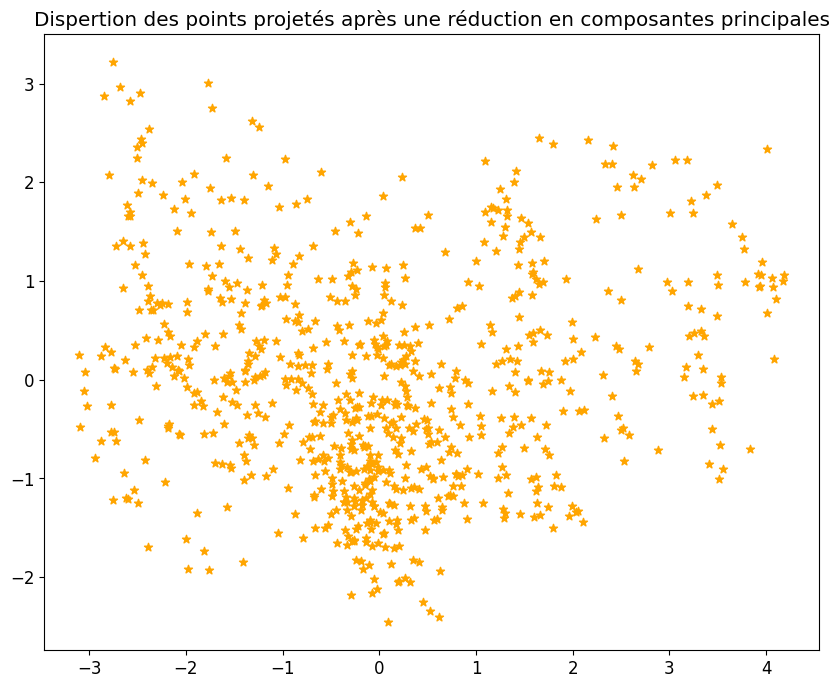

In [9]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_projected[:, 0], X_train_projected[:, 1], color='orange', marker='*')
plt.title("Dispertion des points projetés après une réduction en composantes principales")
plt.show()

### Question 6 (1 pt) 
Pensez-vous utile d'utiliser cette ACP pour réduire la dimension des données pour construire un prédicteur de risque de grossesse difficile ?

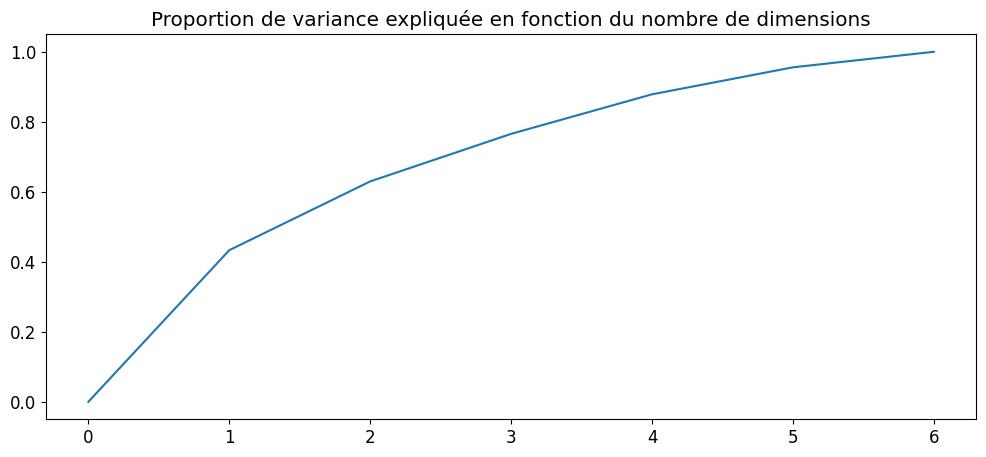

In [10]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(0, 7), np.concatenate((np.array([0]), np.cumsum(decomposition.PCA().fit(X_train_scaled).explained_variance_ratio_))))
plt.title("Proportion de variance expliquée en fonction du nombre de dimensions")
plt.show()

#### Réponse
Le premier terme est plus grand mais les suivants sont tous du même ordre de grandeur, pour atteindre les 95% de variance expliquée, il faut aller jusqu'à la dernière composante exclue, ce qui ne représente pas une diminution significative de la dimension, et remet en question l'utilisation de l'ACP dans ce cas.

### Question 7 (0,5 pt)
Affichez la matrice de corrélation entre les variables (étiquette exclue)

['Age' 'Tension systolique' 'Tension diastolique' 'Glycémie' 'Température'
 'FC au repos']


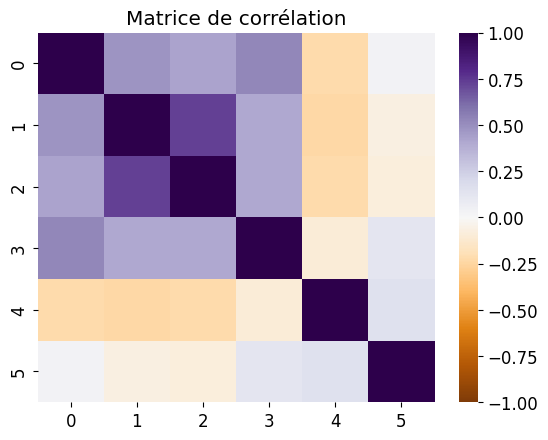

In [11]:
import seaborn as sns

print(df_train.columns[:-1].values)

sns.heatmap(np.cov(X_train_scaled.T), 
            vmin=-1, # borne inf des valeurs à afficher
            vmax=1, # borne sup des valeurs à afficher
            center= 0, # valeur médiane des valeurs à afficher,
            cmap='PuOr', # colormap divergente de violet (PUrple) vers orange (ORange)
           )
plt.title("Matrice de corrélation")
plt.show()

### Question 8 (0,5 pt)

Comment utiliser cette matrice de corrélation pour réduire la dimension des données ?

#### Réponse
Les composantes 2 et 3 sont très corrélées, on peut donc faire une ACP dessus pour en extraire une seule composante et ainsi réduire la dimension de 1. Alternativement, on pourrait faire une ACP sur les 4 premières composantes qui semblre plutôt corrélées entre-elles, et ainsi espérer réduire plus de dimensions.

# 2. Classification «à risque» vs «sans risque»

Nous allons maintenant transformer les étiquettes en étiquettes binaire, en regroupant les risques obstétriques moyens et élevés. Les étiquettes `1` et `2` seront regroupées en une seule étiquette `1`.

In [12]:
# Copier le dataframe initial dans un nouveau dataframe 
df_train_risk_vs_norisk = df_train.copy()

# Regrouper les étiquettes 1 et 2
df_train_risk_vs_norisk['Risque'] = np.where(df_train['Risque']==2, 1, df_train['Risque'])

# Extraction de l'array d'étiquettes
y_train_risk_vs_norisk = np.array(df_train_risk_vs_norisk['Risque'], dtype='int')

## Choix du critère d'évaluation
Pour cette section, on pourra se référer à la section 8.7.1 du poly.

### Question 9 (0,25 pt)
Quelle serait l'_accuracy_ (proportion d'observations correctement étiquetées) d'un modèle qui prédit que toutes les observations appartiennent à la classe majoritaire (c'est-à-dire la classe ayant le plus grand nombre d'observations dans les données) ? 

#### Réponse
Ce serait la proportion d'observations dans cette classe majoritaire (si on considère que cette proportion est la même dans le reste de la population que dans le jeu d'entraînement).

### Question 10 (0,25 pt) 
La __précision équilibrée__ (_balanced accuracy_) d'un classifieur binaire est donnée par :

$$BA = \frac12 \left( \frac{\text{TP}}{\text{TP}+\text{FN}} +  \frac{\text{TN}}{\text{TN}+\text{FP}} \right)$$

Expliquez pourquoi ce critère d'évaluation est plus pertinent que l'accuracy pour sélectionner un classifieur optimal.

#### Réponse
Ce critère prend en compte les proportions d'erreur de manière plus fine, en s'intéressant aux proportions de bonnes réponses 'oui' (resp. 'non') parmi tous les cas qui donnent 'oui' (resp. 'non') comme réponse. 

Dans la suite du projet, nous utiliserons ce critère, implémenté dans la méthode [metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) de scikit-learn.

## Plus proche voisin
L'algorithme du plus proche voisin associe à une observation $\vec{x}$ l’étiquette du point du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 11 (0,5 pt)
En quoi consiste la phase d'entraînement d'un tel classifieur ?

#### Réponse
Il existe plusieurs méthodes pour construire une "carte" de l'espace en fonction du jeu de données. La phase d'entraînement peut simplement consister en la création d'une liste avec les échantillons, et pour tester on parcourerait la liste pour trouver le plus proche voisin. 

Il existe d'autres algorithmes, qui consistent en la création d'arbres $k$-dimensionnels pour découper l'espace et améliorer la complexité de l'algorithme de test (linéaire à logarithmique)

### Question 12 (0,5 pt)
Quelle précision équilibrée attendez-vous _sur le jeu d'entraînement_ d'un algorithme du plus proche voisin ? Pourquoi ?

#### Réponse
Sur le jeu d'entraînement, le point le plus proche de chaque échantillon est lui-même, on va donc forcément l'étiqueter de la bonne manière. La précision équilibrée attendue est donc $1$.

### Question 13 (0,5 pt)
Vérifiez votre réponse sur les données, en utilisant la classe [neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [13]:
from sklearn import neighbors

y_pred_kneighbors = neighbors.KNeighborsClassifier(1).fit(X_train, y_train_risk_vs_norisk).predict(X_train)

BA = 0.5 * (y_pred_kneighbors[y_train_risk_vs_norisk == 0].shape[0] / y_train_risk_vs_norisk[y_train_risk_vs_norisk == 0].shape[0] + 
       y_pred_kneighbors[y_train_risk_vs_norisk == 1].shape[0] / y_train_risk_vs_norisk[y_train_risk_vs_norisk == 1].shape[0])

BA

1.0

### Quesion 14 (0,5 pt)
Pour cet algorithme, vaut-il mieux utiliser les données d'origine ou les données centrées-réduites ? Justifiez votre réponse.

#### Réponse
Il vaut mieux utiliser les données centrées-réduites, puisque sinon on risque d'avoir un énorme biais en défaveur des observations dont l'étendue est grande. 
Par exemple, pour des températures qui varient sur quelques degrés et des âges qui vont de 0 à 100 ans, on peut avoir deux points très éloignés si les âges varient de 4 ans et la température de 1 degré alors que dans la réalité la seconde différence est bien plus significative.

## K plus proches voisins
L'algorithme des $K$ plus proche voisins associe à une observation $\vec{x}$ l’étiquette qui est majoritaires parmi celle des $K$ points du jeu d’entraînement dont elle est la plus proche (par défaut, en distance euclidienne).

### Question 15 (1,5 pt)
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ (voir amphi 7 et PC5) pour déterminer une valeur optimale de $K$. 

* Justifiez votre choix de grille de valeurs.
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [15]:
from sklearn.model_selection import KFold, cross_val_score


K_max = 2 * int(np.sqrt((X_train_scaled.shape[0] * 9/10)) / 2) #Un nombre optimal de voisins est sqrt(N) / 2 selon la littérature, on restreint donc notre recherche à [1, sqrt(N)]
print(K_max)

scores = []

for K in range(1, K_max):
    ten_f = KFold(n_splits=10, shuffle=True, random_state=19)
    KNN = neighbors.KNeighborsClassifier(K)
    scores.append(cross_val_score(KNN, X_train_scaled, y_train_risk_vs_norisk, cv=ten_f, scoring="balanced_accuracy").mean())
    print("Passé", K)
print("Terminé !")

26
Passé 1
Passé 2
Passé 3
Passé 4
Passé 5
Passé 6
Passé 7
Passé 8
Passé 9
Passé 10
Passé 11
Passé 12
Passé 13
Passé 14
Passé 15
Passé 16
Passé 17
Passé 18
Passé 19
Passé 20
Passé 21
Passé 22
Passé 23
Passé 24
Passé 25
Terminé !


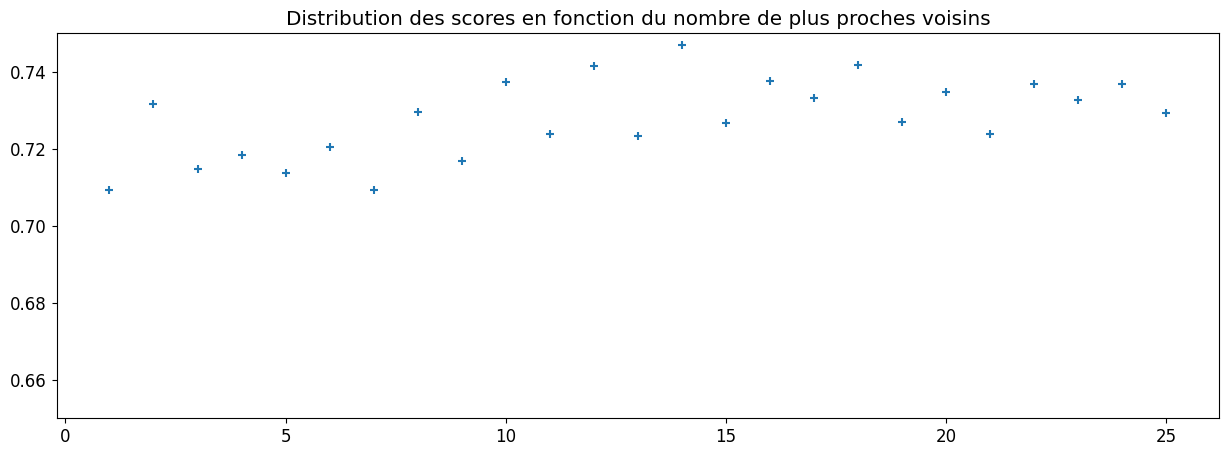

Nombre optimal de voisins (en excluant 1 voisin) : 14
Score max atteint : 0.7468256206508519


In [18]:
plt.figure(figsize=(15, 5))
plt.scatter(np.arange(1, K_max), np.array(scores), marker='+')
plt.ylim(0.65, 0.75)
plt.title("Distribution des scores en fonction du nombre de plus proches voisins")
plt.show()

K_star = np.argmax(np.array(scores)) + 1
print("Nombre optimal de voisins :", K_star)
print("Score max atteint :", np.max(scores))


On remarque un pic en K=14, et on retient cette valeur comme nombre optimal de voisins.

In [19]:
#Calcul de la BA correspondante

KNN = neighbors.KNeighborsClassifier(K_star)
BA_KNN = cross_val_score(KNN, X_train_scaled, y_train_risk_vs_norisk, cv=ten_f, scoring="balanced_accuracy").mean()


print(BA_KNN)

0.7468256206508519


## Régression logistique
Le pendant pour la classification binaire de la régression linéaire (amphi 7 et PC 5) est la __régression logistique__ (PC 6). Dans scikit-learn, elle est implémentée par la classe [linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### Question 16 (1 pt) 
Utilisez une recherche sur grille avec une validation croisée en 10 _folds_ pour déterminer une valeur optimale du coefficient de régularisation d'une régression logistique. 

* Justifiez votre choix de type de régularisation et de grille de valeurs. 
* Illustrez par un graphique approprié votre exploration de cette grille. 
* Commentez ce graphique.
* Reportez la valeur optimale de l'hyperparamètre et la précision équilibrée correspondante.

In [20]:
from sklearn import linear_model

coefs = [10**k for k in range(-10, 10)] + [0.2, 0.4, 0.6, 0.5, 0.7, 0.55, 0.65, 0.75, 0.8, 2, 3, 4, 5, 6, 7, 8, 9, 20, 40, 60, 80] 
#On parcourt de cette manière plusieurs ordres de grandeurs, avec C très petit (donc quasiment aucune pénalité), et C très grand (pénalité prédominante)


scores = []

for a in coefs:
    ten_f = KFold(n_splits=10, shuffle=True, random_state=19)
    model = linear_model.LogisticRegression(penalty='l2', C=a, max_iter=1000) 
    #On choisit la régularisation l2 pour obtenir des choses plus lisses, et parce que la fonction cross_val_score ne fonctionne pas avec la régularisation de Lasso
    scores.append(cross_val_score(model, X_train_scaled, y_train_risk_vs_norisk, cv=ten_f, scoring="balanced_accuracy").mean())
    print("Passé", a)
print("Terminé !")


Passé 1e-10
Passé 1e-09
Passé 1e-08
Passé 1e-07
Passé 1e-06
Passé 1e-05
Passé 0.0001
Passé 0.001
Passé 0.01
Passé 0.1
Passé 1
Passé 10
Passé 100
Passé 1000
Passé 10000
Passé 100000
Passé 1000000
Passé 10000000
Passé 100000000
Passé 1000000000
Passé 0.2
Passé 0.4
Passé 0.6
Passé 0.5
Passé 0.7
Passé 0.55
Passé 0.65
Passé 0.75
Passé 0.8
Passé 2
Passé 3
Passé 4
Passé 5
Passé 6
Passé 7
Passé 8
Passé 9
Passé 20
Passé 40
Passé 60
Passé 80
Terminé !


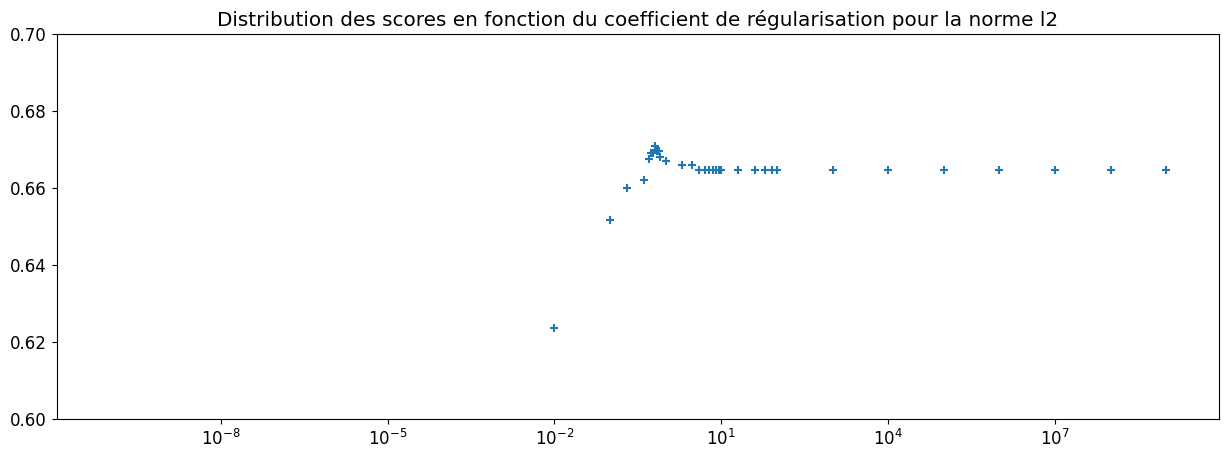

Coefficient optimal : 0.65
Score max atteint : 0.6708423286161643


In [21]:
plt.figure(figsize=(15, 5))
# plt.scatter(np.arange(-10, 10), np.array(scores), marker='+')
plt.scatter(coefs, np.array(scores), marker='+')
plt.xscale("log")
plt.ylim(0.6, 0.7)
plt.title("Distribution des scores en fonction du coefficient de régularisation pour la norme l2")
plt.show()

C_star = np.argmax(np.array(scores))
print("Coefficient optimal :", coefs[C_star])
print("Score max atteint :", np.max(scores))


On remarque que de trop fortes pénalités ($C$ petit, donc la pénalité qui vaut $\frac{1}{C}$ est très grande) apporte un score assez faible, alors que des pénalités moins marquées (voire pas du tout marquées) ne présentent aucune correction du modèle. 

On retient donc $C_{max} = 0.65$ qui présent un bon équilibre de pénalisation

In [28]:
#Calcul de la BA correspondante


model = linear_model.LogisticRegression(penalty='l2', C=coefs[C_star], max_iter=1000) 
BA_logistic = cross_val_score(model, X_train_scaled, y_train_risk_vs_norisk, cv=ten_f, scoring="balanced_accuracy").mean()


print(BA_logistic)

0.6708423286161643


## Algorithme non-linéaire

### Question 17 (2pt)
Choisissez maintenant un algorithme permettant d'apprendre un modèle non-linéaire parmi ceux du chapitre 9 :
* arbre de décision : [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* forêt aléatoire : [ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* machine à vecteur de support à noyau : [svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* perceptron multi-couche : [neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Utilisez encore une fois une recherche sur grille avec une validation croisée en 10 _folds_ pour sélectionner le(s) hyperparamètre(s) le(s) plus pertinent(s).

* Justifiez votre choix d'hyperparamètre(s) à optimiser.
* Justifiez votre choix de grille de valeurs pour ces ou cet hyperparèmtre(s).
* Illustrez par un graphique approprié votre exploration de cette grille.
* Commentez ce graphique.
* Reportez la ou les valeur(s) optimale(s) d'hyperparamètre(s) et la précision équilibrée correspondante.

In [23]:
from sklearn import ensemble

#On choisit d'optimiser le nombre d'arbre dans la forêt. Cela semble un paramètre évident à ajuster mais aussi plutôt facile à interpréter.

ennz = [2**k for k in range(0, 10)] #On choisit ces valeurs pour couvrir plusieurs ordres de grandeurs tout en évitant des temps d'éxecution trop long lorsque n devient très grand


scores = []

for n in ennz:
    ten_f = KFold(n_splits=10, shuffle=True, random_state=19)
    model = ensemble.RandomForestClassifier(n_estimators=n, random_state=19) 
    #On choisit la régularisation l2 pour obtenir des choses plus lisses, et parce que la fonction cross_val_score ne fonctionne pas avec la régularisation de Lasso
    scores.append(cross_val_score(model, X_train_scaled, y_train_risk_vs_norisk, cv=ten_f, scoring="balanced_accuracy").mean())
    print("Passé", n)
print("Terminé !")

#est éxécuté en ~20 secondes

Passé 1
Passé 2
Passé 4
Passé 8
Passé 16
Passé 32
Passé 64
Passé 128
Passé 256
Passé 512
Terminé !


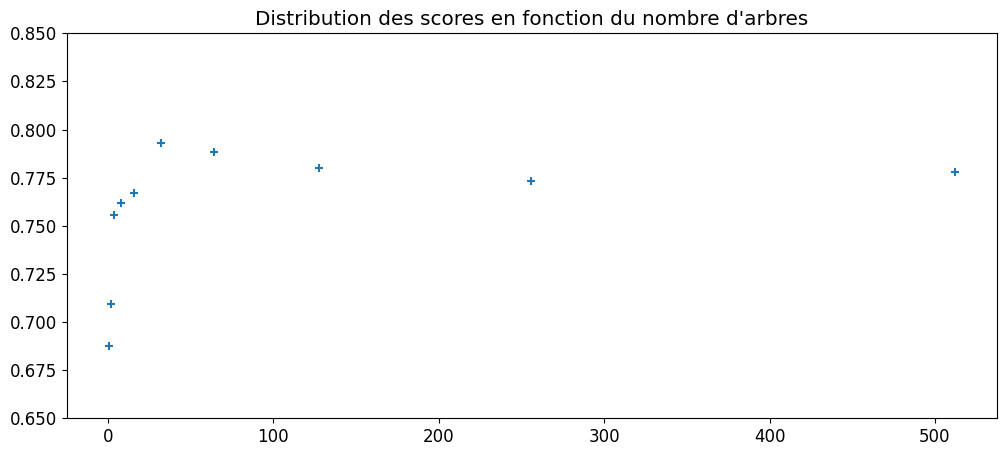

Nombre d'arbres de la forêt optimal : 32
Score max atteint : 0.7930108592116667


In [25]:
plt.figure(figsize=(12, 5))
plt.scatter(ennz, np.array(scores), marker='+')
plt.ylim(0.65, 0.85)
plt.title("Distribution des scores en fonction du nombre d'arbres")
plt.show()

n_star = 2**(np.argmax(np.array(scores)))
print("Nombre d'arbres de la forêt optimal :", n_star)
print("Score max atteint :", np.max(scores))


On remarque que le score est plus bas lorsque $n$ est inférieur à 4. Le maximum est atteint pour $n=32$ ici, et on remarque aussi que le score est beaucoup plus élevé que dans les questions 15 et 16.

In [30]:
#Calcul de la BA correspondante

forest = ensemble.RandomForestClassifier(n_estimators=n_star, random_state=19) 
BA_forest = cross_val_score(forest, X_train_scaled, y_train_risk_vs_norisk, cv=ten_f, scoring="balanced_accuracy").mean()
print("Précision équilibrée =", BA_forest)

Précision équilibrée = 0.7930108592116667


## Classification après réduction de dimension

Nous allons maintenant évaluer l'impact d'une réduction de dimension sur la qualité de l'apprentissage.

### Question 18 (0,25 pt)
Quel algorithme (k plus proches voisins ; régression logistique ; algorithme non-linéaire de la question 16) vous a permis d'obtenir la meilleure performance ? 

In [31]:
print("Affichage des précisions équilibrées pour les trois algorithmes :")
print("KNN :", BA_KNN)
print("Régression logistique :", BA_logistic)
print("Forêt aléatoire :", BA_forest)

Affichage des précisions équilibrées pour les trois algorithmes :
KNN : 0.7468256206508519
Régression logistique : 0.6708423286161643
Forêt aléatoire : 0.7930108592116667


L'algorithme non linéaire des forêts aléatoires est clairement au dessus des deux autres en termes de précision équilibrée.

### Quesion 19 (0,25 pt)
Utilisez le travail des questions 4 à 7 pour créer une nouvelle matrice représentant les données dans moins de dimensions qu'originellement. 

In [32]:
pca_train = decomposition.PCA(n_components=5) #On garde toutes les composantes sauf une pour avoir 95% de variance expliquée
pca_train.fit(X_train_scaled)
X_train_projected = pca_train.transform(X_train_scaled)


### Question 20 (0,25 pt)
Utilisez encore une fois une recherche sur grille pour optimiser les performances de cet algorithme, mais entrainé sur cette nouvelle matrice. 

In [34]:
from sklearn import ensemble

#On choisit d'optimiser le nombre d'arbre dans la forêt. Cela semble un paramètre évident à ajuster mais aussi plutôt facile à interpréter.

ennz = [2**k for k in range(0, 10)] #On choisit ces valeurs pour couvrir plusieurs ordres de grandeurs tout en évitant des temps d'éxecution trop long lorsque n devient très grand


scores = []

for n in ennz:
    ten_f = KFold(n_splits=10, shuffle=True, random_state=19)
    model = ensemble.RandomForestClassifier(n_estimators=n, random_state=19) 
    #On choisit la régularisation l2 pour obtenir des choses plus lisses, et parce que la fonction cross_val_score ne fonctionne pas avec la régularisation de Lasso
    scores.append(cross_val_score(model, X_train_projected, y_train_risk_vs_norisk, cv=ten_f, scoring="balanced_accuracy").mean())
    print("Passé", n)
print("Terminé !")

#est éxécuté en ~20 secondes

Passé 1
Passé 2
Passé 4
Passé 8
Passé 16
Passé 32
Passé 64
Passé 128
Passé 256
Passé 512
Terminé !


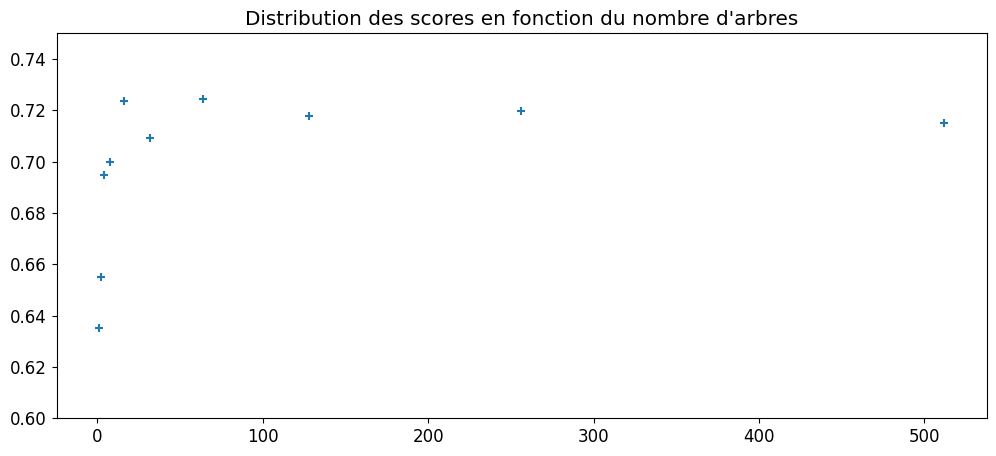

Nombre d'arbres de la forêt optimal : 32
Score max atteint : 0.7243753944272321
Précision équilibrée = 0.7243753944272321


In [36]:
plt.figure(figsize=(12, 5))
plt.scatter(ennz, np.array(scores), marker='+')
plt.ylim(0.6, 0.75)
plt.title("Distribution des scores en fonction du nombre d'arbres")
plt.show()

n_star_projected = 2**(np.argmax(np.array(scores)))
print("Nombre d'arbres de la forêt optimal :", n_star)
print("Score max atteint :", np.max(scores))


#Calcul de la BA correspondante
forest_projected = ensemble.RandomForestClassifier(n_estimators=n_star_projected, random_state=19) 
BA_forest_fold_projected = cross_val_score(forest_projected, X_train_projected, y_train_risk_vs_norisk, cv=ten_f, scoring="balanced_accuracy").mean()
print("Précision équilibrée =", BA_forest_fold_projected)



### Question 21 (0,25 pt)
La réduction de dimension a-t-elle été utile ? Commentez.

In [37]:
print("Réduction de dimension utile ?", BA_forest < BA_forest_fold_projected)

Réduction de dimension utile ? False


#### Réponse
La précision équilibrée sans réduction de dimension est meilleure que celle avec. La réduction de dimension n'a dans ce cas pas vraiment été utile. Le gain de temps d'éxecution est aussi négligeable puisqu'on retire une seule dimension sur 6.

## Classifieur final

### Question 22 (0,25 pt)
Au vu des performances observées jusqu'à présent, quel est l'algorithme d'apprentissage, son ou ses valeurs d'hyperparamètres, la transformation des données qui permettent d'obtenir la meilleure performance ? 

Utilisez cet algorithme pour entraîner un modèle de classification final `final_binary_classifier` sur l'ensemble du jeu d'entraînement.

In [38]:
final_binary_classifier = ensemble.RandomForestClassifier(n_estimators=n_star, random_state=19).fit(X_train_scaled, y_train_risk_vs_norisk)

### Question 23 (0,25 pt)

Chargez les données du jeu de test `data/donnees_reservees.csv`. Combinez les étiquettes 1 et 2 en une seule classe. 

In [39]:
df_reservees = pd.read_csv("data/donnees_reservees.csv")


X_test = np.array(df_reservees.drop(columns="Risque"))
y_test = np.array(df_reservees["Risque"])

# Copier le dataframe initial dans un nouveau dataframe 
df_reservees_risk_vs_norisk = df_reservees.copy()

# Regrouper les étiquettes 1 et 2
df_reservees_risk_vs_norisk['Risque'] = np.where(df_reservees['Risque']==2, 1, df_reservees['Risque'])

# Extraction de l'array d'étiquettes
y_test_risk_vs_norisk = np.array(df_reservees_risk_vs_norisk['Risque'], dtype='int')

### Question 24 (0,25 pt)

Utilisez `final_binary_classifier` pour prédire les étiquettes des observations de ce jeu de données. (N'oubliez pas d'appliquer d'éventuelles transformation des données.) 

In [40]:
X_test_scaled = std_scale.transform(X_test)

y_pred = final_binary_classifier.predict(X_test_scaled)

### Question 25 (0,5 pt)
Comparez la précision équilibrée sur le jeu de test à celle obtenue en validation croisée lors de la sélection de modèle. Commentez.

In [41]:
TN = ((y_pred == 0) & (y_test_risk_vs_norisk == 0)).sum()
Negatives =  (y_pred == 0).sum()
TP = ((y_pred == 1) & (y_test_risk_vs_norisk == 1)).sum()
Positives = (y_pred == 1).sum()
BA_final = 0.5 * (TP / Positives + TN / Negatives)

print(BA_final, BA_forest_fold)

0.8416666666666667 0.7930108592116667


On a une meilleure précision sur le jeu de test que sur le jeu d'entraînement, il peut y avoir eu un léger sous-apprentissage, mais en globalité on est satisfait du résultat.

### Question 26 (0,25 pt)
Utilisez [metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) pour afficher la matrice de confusion de ces prédictions.

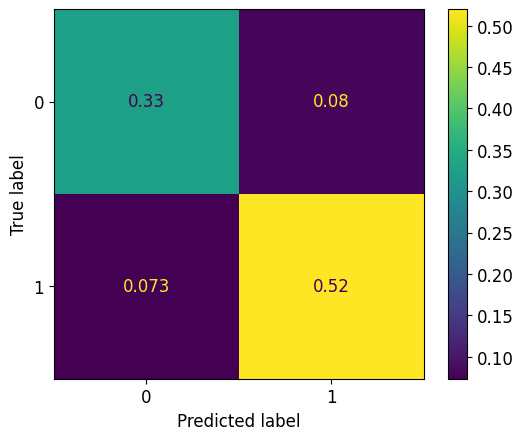

In [42]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_risk_vs_norisk, y_pred, normalize="all")
metrics.ConfusionMatrixDisplay(confusion_matrix).plot()
plt.show()

### Question 27 (0,5 pt)
Commentez cette matrice de précision.

Considéreriez vous possible d'utilise ce classifieur pour décider, sur la base de ces quelques mesures faciles à obtenir en autonomie, quelles femmes référer pour un suivi médical attentif de leur grossesse ?

#### Réponse 
La matrice précédente comporte presque 10% de faux positifs et de faux négatifs. Il paraît impensable de l'utiliser en pratique, surtout au vu du nombre considérable de faux négatifs (1 personne sur 10 que l'on condamnerait peut-être). Le nombre important de faux positifs présente moins de problèmes éthiques mais apporte des contraintes financières et budgétaires.

# 3. Classification multi-classe

### Question 28 (0,5 pt)
Parmi les algorithmes d'apprentissage supervisé que vous avez utilisé dans la section 2, le(s)quel(s) se prête(nt) directement à entraîner un classifieur multiclasse ?

#### Réponse
Les K plus proches voisins, et les forêts alétoires s'y prêtent bien. La régression logistique y est moins adaptée, puisqu'elle se base sur une décomposition de l'espace en deux.

### Question 29 (1,5 pt)
Choisissez un des algorithmes mentionnés à la question précédente et entraînez-le sur le problème de classification multi-classe consistant à prédire le niveau (0, 1 ou 2) de risque obstétrique. Optimisez le ou les hyperparamètre(s) le(s) plus pertinent(s).

In [46]:
from sklearn import ensemble

#On choisit d'optimiser le nombre d'arbre dans la forêt. Cela semble un paramètre évident à ajuster mais aussi plutôt facile à interpréter.

ennz = [2**k for k in range(0, 10)] #On choisit ces valeurs pour couvrir plusieurs ordres de grandeurs tout en évitant des temps d'éxecution trop long lorsque n devient très grand


scores = []

for n in ennz:
    ten_f = KFold(n_splits=10, shuffle=True, random_state=19)
    model = ensemble.RandomForestClassifier(n_estimators=n, random_state=19) 
    #On choisit la régularisation l2 pour obtenir des choses plus lisses, et parce que la fonction cross_val_score ne fonctionne pas avec la régularisation de Lasso
    scores.append(cross_val_score(model, X_train_scaled, y_train, cv=ten_f, scoring="balanced_accuracy").mean())
    print("Passé", n)
print("Terminé !")

#est éxécuté en ~20 secondes

Passé 1
Passé 2
Passé 4
Passé 8
Passé 16
Passé 32
Passé 64
Passé 128
Passé 256
Passé 512
Terminé !


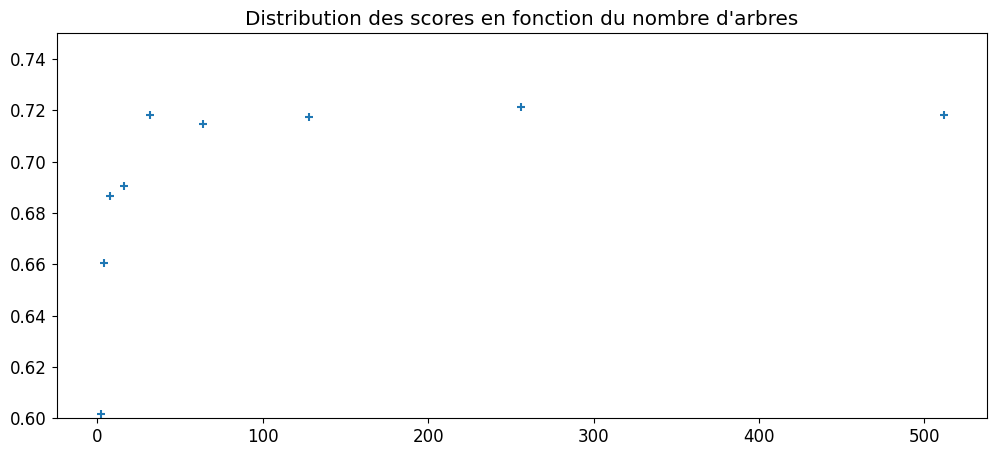

Nombre d'arbres de la forêt optimal : 256
Score max atteint : 0.7214645989313044
Précision équilibrée = 0.7214645989313044


In [49]:
plt.figure(figsize=(12, 5))
plt.scatter(ennz, np.array(scores), marker='+')
plt.ylim(0.6, 0.75)
plt.title("Distribution des scores en fonction du nombre d'arbres")
plt.show()

n_star_trinary = 2**(np.argmax(np.array(scores)))
print("Nombre d'arbres de la forêt optimal :", n_star_trinary)
print("Score max atteint :", np.max(scores))


#Calcul de la BA correspondante
forest_projected = ensemble.RandomForestClassifier(n_estimators=n_star_trinary, random_state=19) 
BA_forest_fold_projected = cross_val_score(forest_projected, X_train_scaled, y_train, cv=ten_f, scoring="balanced_accuracy").mean()
print("Précision équilibrée =", BA_forest_fold_projected)



### Question 30 (1pt)
Utilisez cet algorithme pour entraîner un modèle multi-classe final sur l'ensemble des données d'entraînement. Évaluez ce modèle sur les données de test. Commentez.

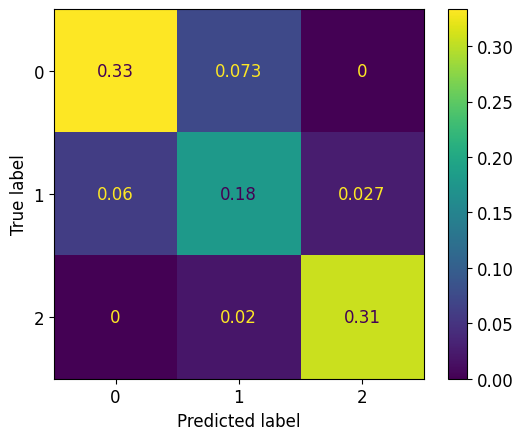

In [50]:
final_trinary_classifier = ensemble.RandomForestClassifier(n_estimators=n_star_trinary, random_state=19)
final_trinary_classifier.fit(X_train_scaled, y_train)

y_pred_trinary = final_trinary_classifier.predict(X_test_scaled)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_trinary, normalize="all")
metrics.ConfusionMatrixDisplay(confusion_matrix).plot()
plt.show()

#### Réponse 
On remarque un nombre d'erreurs plus faible que précédemment, et notamment l'absence de confusion 2/0 ou 0/2, ce qui est une bonne chose. Le modèle est bien plus sûr, toutefois il reste des faux négatifs où 0 a été prédit au lieu de 1, ce qui est bien plus grave que le reste car la personne risque de ne pas du tout avoir de traitement.